In [2]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [9]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import cat2hpx, pandas_to_fits, my_scaler_forward
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import nway_python_api as nway
%matplotlib inline

# LH X-ray catalog

little work with X-ray catalog: duplicates and extended sources

In [51]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

def cross_match_with_itself(xcat, ra_col = 'RA_fin', dec_col = 'DEC_fin', err_col='pos_r98'):
    xcat_matched = xcat.copy()
    c = SkyCoord(ra=xcat[ra_col]*u.degree, dec=xcat[dec_col]*u.degree)
    catalog = SkyCoord(ra=xcat[ra_col]*u.degree, dec=xcat[dec_col]*u.degree)
    idx, ero2ero, _ = c.match_to_catalog_sky(catalog, nthneighbor=2)
    ero2ero = ero2ero.to(u.arcsec).value

    xcat_matched['sep_to_closest'] = ero2ero
    xcat_matched.loc[:, 'closest_srcname_fin']  = xcat_matched.iloc[idx]['srcname_fin'].values[0]
    xcat_matched = xcat_matched.merge(xcat.rename(columns={'srcname_fin':'closest_srcname_fin'}), on='closest_srcname_fin', how='left', suffixes=('', '_closest'))

    xcat_matched['is_confused'] = xcat_matched.eval('sep_to_closest<sqrt( pos_r98**2 + pos_r98_closest**2 )/2')
    xcat_matched['ML_FLUX_0_ratio'] = xcat_matched.ML_FLUX_0/xcat_matched.ML_FLUX_0_closest
    xcat_matched['ML_CTS_0_ratio']  = xcat_matched.ML_CTS_0/xcat_matched.ML_CTS_0_closest
    xcat_matched['DET_LIKE_0_ratio'] = xcat_matched.DET_LIKE_0/xcat_matched.DET_LIKE_0_closest

    
    return xcat_matched
xcat_matched = cross_match_with_itself(xcat_orig)
xcat_matched

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,sep_to_closest,closest_srcname_fin,RA_fin_closest,DEC_fin_closest,GLON_closest,GLAT_closest,pos_r98_closest,DET_LIKE_0_closest,ML_FLUX_0_closest,ML_FLUX_ERR_0_closest,ML_CTS_0_closest,ML_CTS_ERR_0_closest,ML_EXP_1_closest,EXT_closest,EXT_LIKE_closest,EXT_ERR_closest,ID_SRC_closest,ID_CLUSTER_closest,RA_closest,DEC_closest,RADEC_ERR_closest,DIST_NN_closest,SRCDENS_closest,TSTART_closest,TSTOP_closest,EXT_LOWERR_closest,EXT_UPERR_closest,ML_RATE_0_closest,ML_RATE_ERR_0_closest,ML_BKG_0_closest,RA_corr_closest,DEC_corr_closest,g_id_closest,g_d2d_closest,g_nsrc_closest,g_s_closest,g_gmag_closest,g_maxLx_closest,g_b_closest,s_id_closest,s_z_closest,s_otype_closest,s_d2d_closest,s_nsrc_closest,flag_xray_closest,flag_radio_closest,flag_agn_wise_closest,w1_closest,w2_closest,w3_closest,w1snr_closest,w2snr_closest,w3snr_closest,w_nsrc_closest,sdss_nsrc_closest,sdss_p_closest,sdss_id_closest,sdss_sp_closest,sdss_d2d_closest,hpidx_closest,RADEC_ERR_fin_closest,pos_sigma_2d_closest,pos_r68_closest,pos_r95_closest,ELON_closest,ELAT_closest,flux_05-20_closest,NH_closest,is_confused,ML_FLUX_0_ratio,ML_CTS_0_ratio,DET_LIKE_0_ratio
0,SRGe J103744.3+571156,159.434594,57.198788,151.771105,51.782607,2.041112,26414.902344,3.284168e-12,3.904461e-13,15460.503906,1838.058594,4300.765625,0.000000,0.000000,0.000000,1,1,159.436603,57.197499,0.318530,6.785297,0.000011,6.268413e+08,6.270701e+08,0.00000,0.000000,3.594826,0.427379,20.898417,159.434594,57.198788,853989860956388736,6.040749,1,0,15.749939,-1.0,0,87GB 103431.3+572750,0.830700,BLLac,6.040664,4,1,1,1,12.218000,11.328000,9.144,46.2,51.7,34.4,1,3,1,1237658303278743603,7980433077213351936,6.099201,65741514189,0.318530,0.729711,1.101567,1.786149,134.901685,44.066998,2.527295e-12,5.451755e+19,6.785286,SRGe J103744.5+571149,159.435353,57.196949,151.773056,51.784054,9.921291,45.61993,2.632385e-13,7.630831e-14,1239.217773,359.227936,4300.765625,9.686548,962.11145,0.160101,2,1,159.437361,57.195659,4.356912,6.785297,0.000011,6.268413e+08,6.270701e+08,0.160101,NaN,0.288139,0.083527,20.898417,159.435353,57.196949,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1237658303278743995,0,2.109734,65748766508,4.356912,3.546929,5.354416,8.681984,134.903501,44.065638,2.025723e-13,5.449070e+19,False,12.476019,12.476019,579.021118
1,SRGe J110137.5+572926,165.406353,57.490464,147.861359,53.996717,2.144203,5344.646973,1.969860e-12,5.570020e-14,1436.945923,40.631405,666.426941,0.000000,0.000000,0.000000,21,14,165.408362,57.489175,0.433455,41.040825,0.000030,6.268413e+08,6.270701e+08,0.00000,0.000000,2.156194,0.060969,4.025409,165.406353,57.490464,857143329024245888,7.121849,2,1,10.012074,NaN,0,HD 237963,NaN,Star,7.105646,1,1,0,0,8.146000,8.155000,8.124,47.2,55.3,51.5,1,3,1,1237658302206378052,0,3.844748,64609311305,0.433455,0.766567,1.157204,1.876362,138.528408,46.042071,1.515884e-12,7.056474e+19,41.039381,SRGe J103744.5+571149,159.435353,57.196949,151.773056,51.784054,9.921291,45.61993,2.632385e-13,7.630831e-14,1239.217773,359.227936,4300.765625,9.686548,962.11145,0.160101,2,1,159.437361,57.195659,4.356912,6.785297,0.000011,6.268413e+08,6.270701e+08,0.160101,NaN,0.288139,0.083527,20.898417,159.435353,57.196949,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1237658303278743995,0,2.109734,65748766508,4.356912,3.546929,5.354416,8.681984,134.903501,44.065638,2.025723e-13,5.449070e+19,False,7.483177,1.159559,117.155968
2,SRGe J105825.0+564723,164.

In [57]:
xcat_matched.groupby(['is_confused'])[['ML_FLUX_0_ratio', 'ML_CTS_0_ratio', 'DET_LIKE_0_ratio']].agg(['mean', 'std'])

ML_FLUX_0_ratio          ML_CTS_0_ratio            \
                       mean      std           mean       std   
is_confused                                                     
False              0.063740  0.22397       0.052390  0.180960   
True               0.482533  0.71809       0.486534  0.754053   

            DET_LIKE_0_ratio             
                        mean        std  
is_confused                              
False               1.896403  12.188146  
True               16.217451  30.879796

In [50]:
print(xcat_matched.query("EXT>0").groupby('is_confused')[['DET_LIKE_0', 'EXT']].agg(['count', 'mean', 'std']))
print(xcat_matched.query("EXT==0").groupby('is_confused')[['DET_LIKE_0', 'EXT']].agg(['count', 'mean', 'std']))

            DET_LIKE_0                           EXT                      
                 count        mean         std count       mean        std
is_confused                                                               
False              266  128.686600  347.079193   266  22.203962  11.484367
True                 6  380.916168  560.886336     6  26.602545  20.122130
            DET_LIKE_0                            EXT          
                 count        mean          std count mean  std
is_confused                                                    
False             9197   85.294037   560.873607  9197  0.0  0.0
True                31  809.307861  1515.999339    31  0.0  0.0


In [44]:
xcat_matched.groupby('is_confused')[['DET_LIKE_0', 'EXT']].agg(['count', 'mean', 'std'])

DET_LIKE_0                             EXT                     
                 count         mean          std count      mean        std
is_confused                                                                
False             9447    83.027985   482.435854  9447  0.607019   4.061051
True                53  1163.935059  3803.777958    53  6.252018  14.561959

In [19]:
len(idx)

9500

Read catalog and create a fits table with positions and positional errors

In [3]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

positional_error_columns = 'pos_sigma_2d'
print('*'*50)
print('using positional error columns:', positional_error_columns)
print('*'*50)

columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', positional_error_columns, 'ML_FLUX_0'] 


xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', positional_error_columns:'pos_err', 'srcname_fin': 'ID'}, inplace=True)

def pos_err_correction(err):
    print('*'*50)
    print('using corrected positional error columns: 1.0*', positional_error_columns)
    print('*'*50)
    return err*1.0

xcat['pos_err'] = xcat['pos_err'].apply(pos_err_correction)

**************************************************
using positional error columns: pos_sigma_2d
**************************************************


In [4]:
print(1.101567/0.729711) #r68 
print(1.786149/0.729711) #r95
print(2.041112/0.729711) #r98


1.5095935240115608
2.4477484922113
2.7971512009548984


In [4]:
xcat_orig.head(2)

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
0,SRGe J103744.3+571156,159.434594,57.198788,151.771105,51.782607,2.041112,26414.902344,3.284168e-12,3.904461e-13,15460.503906,1838.058594,4300.765625,0.0,0.0,0.0,1,1,159.436603,57.197499,0.318530,6.785297,0.000011,6.268413e+08,6.270701e+08,0.0,0.0,3.594826,0.427379,20.898417,159.434594,57.198788,853989860956388736,6.040749,1,0,15.749939,-1.0,0,87GB 103431.3+572750,0.8307,BLLac,6.040664,4,1,1,1,12.218,11.328,9.144,46.2,51.7,34.4,1,3,1,1237658303278743603,7980433077213351936,6.099201,65741514189,0.318530,0.729711,1.101567,1.786149,134.901685,44.066998,2.527295e-12,5.451755e+19
1,SRGe J110137.5+572926,165.406353,57.490464,147.861359,53.996717,2.144203,5344.646973,1.969860e-12,5.570020e-14,1436.945923,40.631405,666.426941,0.0,0.0,0.0,21,14,165.408362,57.489175,0.433455,41.040825,0.000030,6.268413e+08,6.270701e+08,0.0,0.0,2.156194,0.060969,4.025409,165.406353,57.490464,857143329024245888,7.121849,2,1,10.012074,NaN,0,HD 237963,NaN,Star,7.105646,1,1,0,0,8.146,8.155,8.124,47.2,55.3,51.5,1,3,1,1237658302206378052,0,3.844748,64609311305,0.433455,0.766567,1.157204,1.876362,138.528408,46.042071,1.515884e-12,7.056474e+19


In [5]:
xcat_orig[['pos_r98', 'pos_sigma_2d', 'pos_r68', 'pos_r95']].describe().loc[['mean', 'std', '25%', '50%', '75%']]

,pos_r98,pos_sigma_2d,pos_r68,pos_r95
mean,8.311198,2.971310,4.485466,7.273014
std,4.529825,1.619443,2.444699,3.963987
25%,5.779061,2.066054,3.118898,5.057176
50%,7.927672,2.834197,4.278481,6.937396
75%,9.985523,3.569892,5.389082,8.738193


## area and plotting

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel
18.385776415407125 sq. deg.


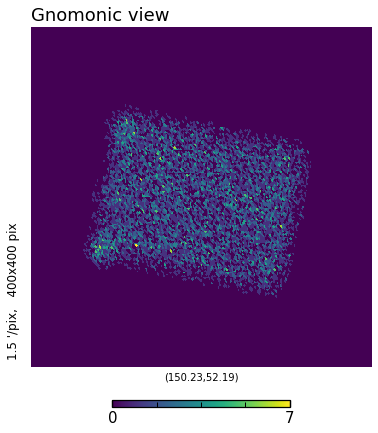

In [6]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [7]:
pandas_to_fits(dataframe = xcat, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)

In [8]:
xcat[['RA', 'DEC']].describe().loc[['min', 'max']]

,RA,DEC
min,154.763934,54.124219
max,167.084550,61.236185


## Random catalog

In [9]:
nway.create_shifted_catalogue(inputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', outputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits', shift_dec=300, radius=40)

opening /Users/sdbykov/work/lockman_hole/0_data/ERO_lhpv_03_23_sd01_a15_g14.fits
    using RA  column: RA
    using DEC column: DEC


100%|██████████| 9500/9500 [00:06<00:00, 1549.49it/s]


removed 1325 sources which collide with original positions
writing "/Users/sdbykov/work/lockman_hole/0_data/ERO_lhpv_03_23_sd01_a15_g14_shifted.fits" (8175 rows)
